<Axes: ylabel='Frequency'>

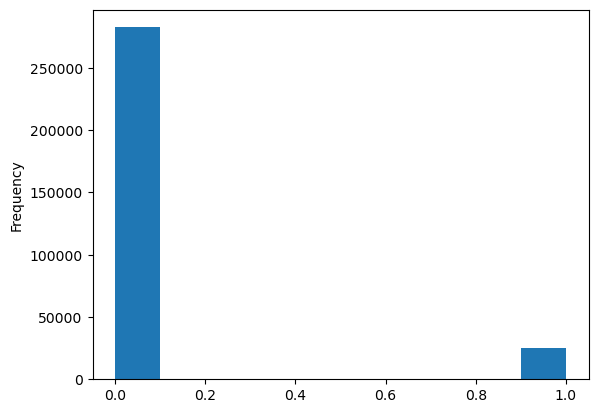

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
df_train=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/application_train.csv")
df_test=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/application_test.csv")
df_train["TARGET"].astype("int").plot.hist()   # hist()  用于绘制直方图的函数，

In [11]:
# 建立一个函数来计算每一列的缺失值以及缺失比例，以及提取出缺失的
def detect_null_columns(df):
    null_counts=df.isnull().sum()
    null_values=df[df.isnull().any(axis=1)]   #提取包含缺失值的行（只要行中有一个缺失值就保留）
    null_rate=100*null_counts/len(df)
    null_df=pd.concat([null_counts,null_rate],axis=1)
    null_df.columns=["null_counts","null_rate(%)"]
    null_df["null_rate(%)"]=pd.to_numeric(null_df["null_rate(%)"],errors="coerce")
    null_df["null_group"]=0
    null_df["null_group"][null_df["null_rate(%)"]<10]="Below 10%"
    null_df["null_group"][(null_df["null_rate(%)"]>=10)&(null_df["null_rate(%)"]<20)]="10% to 20%"
    null_df["null_group"][(null_df["null_rate(%)"]>=20)&(null_df["null_rate(%)"]<40)]="20% to 40%"
    null_df["null_group"][(null_df["null_rate(%)"]>=40)&(null_df["null_rate(%)"]<60)]="40% to 60%"
    null_df["null_group"][null_df["null_rate(%)"]>=60]="Above 60%"
    null_df=null_df[null_df.iloc[:,1]!=0].sort_values("null_rate(%)",ascending=False)   # 降序排列
    null_df=null_df.reset_index()
    null_df=null_df.rename(columns={"index":"columns"})
    return null_df,null_values
null_df,null_values=detect_null_columns(df_train)

#null_df["columns"][(null_df["null_group"]=="10% to 20%")]

null_df["columns"][(null_df["null_group"]=="10% to 20%") | (null_df["null_group"]=="20% to 40%")]    # 此时的列有OCCUPATION_TYPE（职业类型）以及Exit_source（外部对该用户的评分3）
#df_train["OCCUPATION_TYPE"].head(20)

49               OCCUPATION_TYPE
50                  EXT_SOURCE_3
51    AMT_REQ_CREDIT_BUREAU_WEEK
52     AMT_REQ_CREDIT_BUREAU_DAY
53     AMT_REQ_CREDIT_BUREAU_MON
54     AMT_REQ_CREDIT_BUREAU_QRT
55    AMT_REQ_CREDIT_BUREAU_HOUR
56    AMT_REQ_CREDIT_BUREAU_YEAR
Name: columns, dtype: object

In [ ]:
##### 先整体对数值型变量与非数值型变量特征进行分析
# 上述对缺失率的进行了分组，接下来就是要对缺失值就行分别填充。
# 对于缺失率较小的，连续特征使用平均值进行填充。离散值使用众数进行填充
#对于缺失率在10%-40%的，连续特征，和离散特征都使用NA
# 对于缺失率在40以上的，可以删除了

def fill_out_columns(df):
    null_df,null_values=detect_null_columns(df)
    null_df=null_df.copy()
    missed_out_columns=null_df["columns"][(null_df["null_group"]=="40% to 60%") | (null_df["null_group"]=="Above 60%")]   #  在 pandas 中，对 Series 做逻辑运算要用 |（或）和 &（与），并且要加括号。
    df.drop(missed_out_columns,axis=1,inplace=True)

    filled_columns=null_df["columns"][(null_df["null_group"]=="Below 10%") | (null_df["null_group"]=="10% to 20%")]
    # 判断每列是否为数值型（连续型）
    numeric_cols=df.select_dtypes(include=[np.number]).columns.intersection(filled_columns)   # intersection()适用于两个长度不匹配的取交集，而&  和| 适用于Series中长度相匹配的内容
    category_cols=[col for col in filled_columns if df[col].dtype == 'object']

    df[numeric_cols]=df[numeric_cols].fillna(df[numeric_cols].median())
    ## 众数不是只出现一次，对于
    for col in category_cols:
        mode_value = df[col].mode()
        if not mode_value.empty:
            df[col].fillna(mode_value[0], inplace=True)
    
    stay_cols=null_df["columns"][(null_df["null_group"]=="20% to 40%")]    # 由于这时候发现空缺值在10%到20%的是外部数据对客户的评分_3，所以此时临时更改这里的保留数据列只是OCCUPATION_TYPE（职业类型）
    if not stay_cols.empty:
        stay_numeric = df.select_dtypes(include=[np.number]).columns.intersection(stay_cols)  # 该保留的列中是数值类型的
        stay_category = [col for col in stay_cols if df[col].dtype == 'object']
        if len(stay_category) > 0:
            df[stay_category] = df[stay_category].fillna("NA")
        if len(stay_numeric) > 0:
            df[stay_numeric] = df[stay_numeric].fillna(df[stay_numeric].median())          # 缺失的用中位数去填充
    return df 
df=fill_out_columns(df=df_train.copy())
print(df['AMT_ANNUITY'])





0         24700.5
1         35698.5
2          6750.0
3         29686.5
4         21865.5
           ...   
307506    27558.0
307507    12001.5
307508    29979.0
307509    20205.0
307510    49117.5
Name: AMT_ANNUITY, Length: 307511, dtype: float64


In [13]:
Target=df_train.TARGET.copy()
master=pd.concat([df_train,df_test]).reset_index(drop=True).drop("TARGET",axis=1)   # 重置索引，避免原数据的索引混乱（比如训练集是 0~999，测试集是 0~499，合并后会有重复索引）
master.shape

(356255, 121)

In [14]:
master=fill_out_columns(df=master)
master_null_df,master_null_values=detect_null_columns(master)
master_null_df
master.shape

(356255, 72)

In [15]:
## 筛选出哪些是连续特征标签
def con_name(df,binary_include = False):
    cols=list(filter(lambda x: df[x].dtype not in ["object","O"],df.columns))   # 先剔除非数值性特征
    if binary_include:
        return cols    # 直接返回所有数值连续型列
    else:
        bin_cols=list(filter(lambda x: df[x].isin([0,1]).sum()==df.shape[0],df.columns))  # 如果x列中的每一行的值都是0，或者1，则为二分类特征

    return list(set(cols) - set(bin_cols))  # 只保留“真正连续”的数值列。
# 那些是非数值型特征
def cat_name(df):
    return list(filter(lambda x: df[x].dtype in ["object","O"],df.columns))
master_contin_name=con_name(master,binary_include=False)
master_contin_name
master_cat_name=cat_name(master)
master_cat_name


['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [16]:
#################先对非数值型特征标签进行处理
## 返回一个 DataFrame，展示每个分类变量各自的类别数量。
def level_summary(dat):
    cols = list(filter(lambda x: dat[x].dtype in ['object','O'],dat.columns))
    dist_level = {}
    for col in cols:
        dist_level[col] = [dat[col].nunique()]     #  用单元素列表绕过标量限制
    return pd.DataFrame(dist_level).T.sort_values(0).rename(columns={0:"Number of features"})
level_summary(master)
## 结果展示在ORGANIZATION_TYPE，OCCUPATION_TYPE	的分类类别众多，可能会出现单一类别出现的频率极低(小于5%)，而类别不平衡问题可能导致模型拟合偏差或泛化能力差。同时如果类别数量多，会造成独热编码的复杂
#3 下面的内容是对分类标签下的类别的EDA

,Number of features
NAME_CONTRACT_TYPE,2
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
CODE_GENDER,3
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
NAME_TYPE_SUITE,7
WEEKDAY_APPR_PROCESS_START,7
NAME_INCOME_TYPE,8


In [17]:
# 将各子类别的比例按升序排列；
# 如果最小比例小于 5%，则该特征被认为是不平衡的；
# 列出该特征中所有出现比例小于 5% 的子类别。
def unbal_cate(dat):
    cols  = dat.select_dtypes(include=['object', 'category']).columns.tolist() # 全部的分类变量
    unbal = {}
    for col in cols:
        if dat[col].nunique() in [1, 2]:
            continue  # 跳过单类/双类
        else:
            counts = dat[col].value_counts()
            # print("!!!!")
            # print(counts)
            if min(counts)/dat.shape[0]<=0.05:
                unbal[col] = counts[counts/dat.shape[0] < 0.05].index.tolist()  # 接下来不能直接使用pd.DataFrame
    return unbal
unbal_dict=unbal_cate(master.copy())
result=pd.Series(unbal_dict)
unbal_df=result.to_frame()
unbal_df.rename(columns={0:"Unbalanced levels"},inplace=True)
unbal_df

,Unbalanced levels
CODE_GENDER,[XNA]
NAME_TYPE_SUITE,"[Spouse, partner, Children, Other_B, Other_A, ..."
NAME_INCOME_TYPE,"[Unemployed, Student, Businessman, Maternity l..."
NAME_EDUCATION_TYPE,"[Incomplete higher, Lower secondary, Academic ..."
NAME_FAMILY_STATUS,[Unknown]
NAME_HOUSING_TYPE,"[With parents, Municipal apartment, Rented apa..."
OCCUPATION_TYPE,"[High skill tech staff, Accountants, Medicine ..."
ORGANIZATION_TYPE,"[Medicine, Business Entity Type 2, Government,..."


In [18]:
# 这些处理的仍然是非数值型特征标签 
# 对于分类类别>=3 的将出现比例小于 5% 的类别进行分组；检查新合并后的子组是否出现比例 ≥ 5%。如果不是，则将其与下一个最接近的类别继续合并。
# 对于分类类别<=2的，直接删除.首先只有一个类别，没什么分析的意义
def rebalance_cate(df):
    cols_dict=unbal_cate(df)
    print("分类变量中的某个类别的频率出现小于5%")
    print(cols_dict)
    if not cols_dict :
        print("分类变量很完美，可以退出了")
        return df
    for key,val in cols_dict.items():
        if df[key].nunique() in [1,2]:
            df=df.drop([key],axis=1)
        else:
            df[key][df[key].isin(val)]="Others (new)"      # 合并成这里新的"Others (new)" 
            if df[key].value_counts()["Others (new)"]/df.shape[0]<=0.05:   
                if df[key].nunique()==2:  # 如果合并后还是出现了频率低于0.05的类别且只有两个类别时，删除
                    df.drop([key],axis=1)
                else:
                    level=df[key].value_counts(ascending=True).reset_index().iloc[1,0]  # 取升序第2行第1列的内容，也就是出现频率最低的那一个类别，并更改名字
                    df[key][df[key].isin(["Others (new)",level])]=level+ " and "+ " Others (new) "
    return df
rebalance_df=rebalance_cate(master.copy())
rebalance_df.head()


分类变量中的某个类别的频率出现小于5%
{'CODE_GENDER': ['XNA'], 'NAME_TYPE_SUITE': ['Spouse, partner', 'Children', 'Other_B', 'Other_A', 'Group of people'], 'NAME_INCOME_TYPE': ['Unemployed', 'Student', 'Businessman', 'Maternity leave'], 'NAME_EDUCATION_TYPE': ['Incomplete higher', 'Lower secondary', 'Academic degree'], 'NAME_FAMILY_STATUS': ['Unknown'], 'NAME_HOUSING_TYPE': ['With parents', 'Municipal apartment', 'Rented apartment', 'Office apartment', 'Co-op apartment'], 'OCCUPATION_TYPE': ['High skill tech staff', 'Accountants', 'Medicine staff', 'Security staff', 'Cooking staff', 'Cleaning staff', 'Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 'Realty agents', 'HR staff', 'IT staff'], 'ORGANIZATION_TYPE': ['Medicine', 'Business Entity Type 2', 'Government', 'School', 'Trade: type 7', 'Kindergarten', 'Construction', 'Business Entity Type 1', 'Transport: type 4', 'Trade: type 3', 'Industry: type 9', 'Industry: type 3', 'Security', 'Housing', 'Military', 'Industry:

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M and Others (new),N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M and Others (new),Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,Cash loans,M and Others (new),N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
### 下面是对二分类变量中的标注自己是[0,1]的进行处理
def binarynum_detect(df):
    names=[]
    bin_cols=list(filter(lambda x: df[x].isin([0,1]).sum()==df.shape[0],df.columns))  # 如果x列中的每一行的值都是0，或者1，则为二分类特征
    for col in bin_cols:
        if df[col].nunique()==2 and min(df[col].value_counts())/df.shape[0]<=0.05:
            names.append(col)
    return names
binarynum_names=binarynum_detect(master.copy())
rebalance_df_2=rebalance_df.drop(binarynum_names,axis=1)

# 把处理好的train和test再分开
TARGET = df_train.TARGET.copy()
train_app=rebalance_df_2[rebalance_df_2["SK_ID_CURR"].isin(df_train.SK_ID_CURR.values)]
train_app['TARGET'] = TARGET
test_app =rebalance_df_2[rebalance_df_2["SK_ID_CURR"].isin(df_test.SK_ID_CURR.values)]
test_app
train_app['CODE_GENDER'].unique()
train_app.shape

(307511, 52)

In [12]:
# 按照上述对数值型特征和非数值型特征的处理对HCD中的其他文件一同进行处理
bureau=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/bureau.csv")
bureau_balance=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/bureau_balance.csv")
credit_card_balance=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/credit_card_balance.csv")
installments_payments=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/installments_payments.csv")
POS_CASH_balance=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/POS_CASH_balance.csv")
previous_application=pd.read_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/previous_application.csv")

bureau=fill_out_columns(bureau.copy())
bureau_df_2=rebalance_cate(bureau.copy())
bureau_binarynum_names=binarynum_detect(bureau.copy())
bureau_df=bureau_df_2.drop(bureau_binarynum_names,axis=1)
bureau_df.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/discard_missing/bureau.csv")

bureau_balance=fill_out_columns(bureau_balance.copy())
bureau_balance_df_2=rebalance_cate(bureau_balance.copy())
bureau_balance_binarynum_names=binarynum_detect(bureau_balance.copy())
bureau_balance_df=bureau_balance_df_2.drop(bureau_balance_binarynum_names,axis=1)
bureau_balance_df.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/discard_missing/bureau_balance.csv")

credit_card_balance=fill_out_columns(credit_card_balance.copy())
credit_card_balance_df_2=rebalance_cate(credit_card_balance.copy())
credit_card_balance_binarynum_names=binarynum_detect(credit_card_balance.copy())
credit_card_balance_df=credit_card_balance_df_2.drop(credit_card_balance_binarynum_names,axis=1)
credit_card_balance_df.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/discard_missing/credit_card_balance.csv")

installments_payments=fill_out_columns(installments_payments.copy())
installments_payments_df_2=rebalance_cate(installments_payments.copy())
installments_payments_binarynum_names=binarynum_detect(installments_payments.copy())
installments_payments_df=installments_payments_df_2.drop(installments_payments_binarynum_names,axis=1)
installments_payments_df.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/discard_missing/installments_payments.csv")

POS_CASH_balance=fill_out_columns(POS_CASH_balance.copy())
POS_CASH_balance_df_2=rebalance_cate(POS_CASH_balance.copy())
POS_CASH_balance_binarynum_names=binarynum_detect(POS_CASH_balance.copy())
POS_CASH_balance_df=POS_CASH_balance_df_2.drop(POS_CASH_balance_binarynum_names,axis=1)
POS_CASH_balance_df.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/discard_missing/POS_CASH_balance.csv")

previous_application_1=fill_out_columns(previous_application.copy())
#print(previous_application_1.head())
previous_application_df_2=rebalance_cate(previous_application_1)
previous_application_binarynum_names=binarynum_detect(previous_application.copy())
print(previous_application_binarynum_names)
previous_application_df=previous_application_df_2.drop(previous_application_binarynum_names,axis=1)
previous_application_df.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/discard_missing/previous_application.csv")

#previous_application_df



分类变量中的某个类别的频率出现小于5%
{'CREDIT_ACTIVE': ['Sold', 'Bad debt'], 'CREDIT_CURRENCY': ['currency 2', 'currency 3', 'currency 4'], 'CREDIT_TYPE': ['Car loan', 'Mortgage', 'Microloan', 'Loan for business development', 'Another type of loan', 'Unknown type of loan', 'Loan for working capital replenishment', 'Cash loan (non-earmarked)', 'Real estate loan', 'Loan for the purchase of equipment', 'Loan for purchase of shares (margin lending)', 'Mobile operator loan', 'Interbank credit']}
分类变量中的某个类别的频率出现小于5%
{'STATUS': ['1', '5', '2', '3', '4']}
分类变量中的某个类别的频率出现小于5%
{'NAME_CONTRACT_STATUS': ['Completed', 'Signed', 'Demand', 'Sent proposal', 'Refused', 'Approved']}
分类变量中的某个类别的频率出现小于5%
{}
分类变量很完美，可以退出了
分类变量中的某个类别的频率出现小于5%
{'NAME_CONTRACT_STATUS': ['Signed', 'Demand', 'Returned to the store', 'Approved', 'Amortized debt', 'Canceled', 'XNA']}
分类变量中的某个类别的频率出现小于5%
{'NAME_CONTRACT_TYPE': ['XNA'], 'NAME_CASH_LOAN_PURPOSE': ['Repairs', 'Other', 'Urgent needs', 'Buying a used car', 'Building a house or an annex

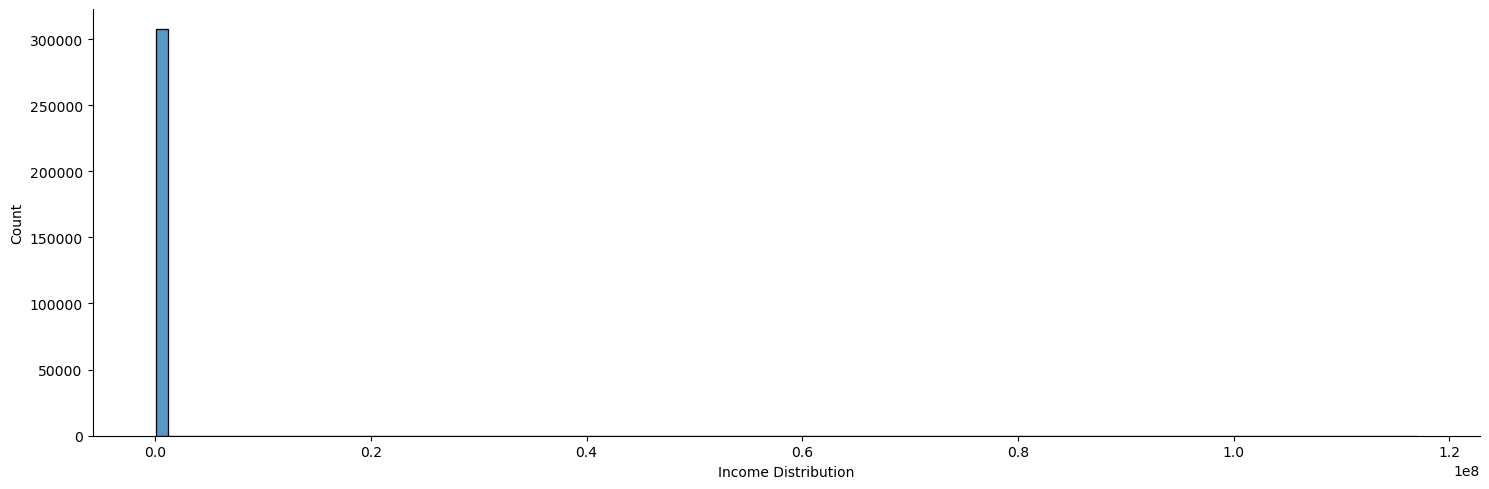

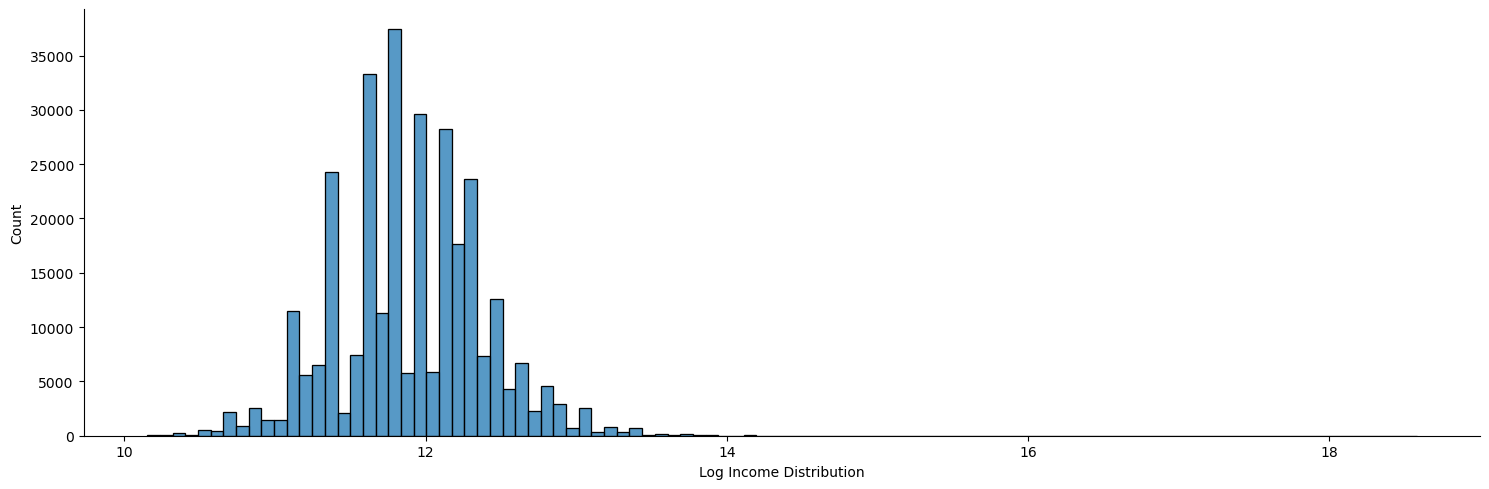

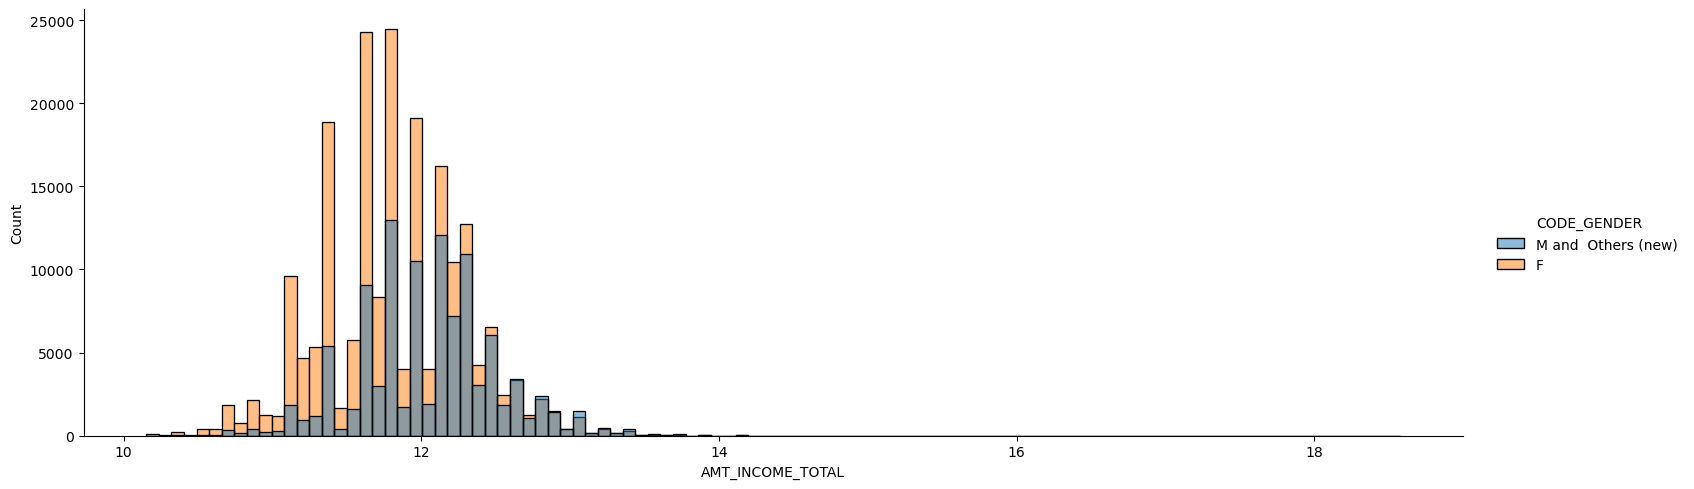

In [ ]:
dist1=sns.displot(train_app,x="AMT_INCOME_TOTAL",kde=False,bins=100, height=5, aspect=3)
dist1.set_axis_labels("Income Distribution")
dist2 = sns.displot(np.log(train_app.AMT_INCOME_TOTAL+1), kde=False, bins=100, height=5,aspect=3)
dist2.set_axis_labels("Log Income Distribution")

#  对于未清理前的客户收入情况的统计可知还是右偏性的正态分布，而求对数之后的更可见这里符合一个正太分布.

# 如果关于性别的分类
sns.displot(train_app,x=np.log(train_app.AMT_INCOME_TOTAL),hue='CODE_GENDER',kde=False, bins=100, height=5,aspect=3)
#可以发现女性的收入情况并不少

<Axes: xlabel='AMT_INCOME_TOTAL', ylabel='NAME_CONTRACT_TYPE'>

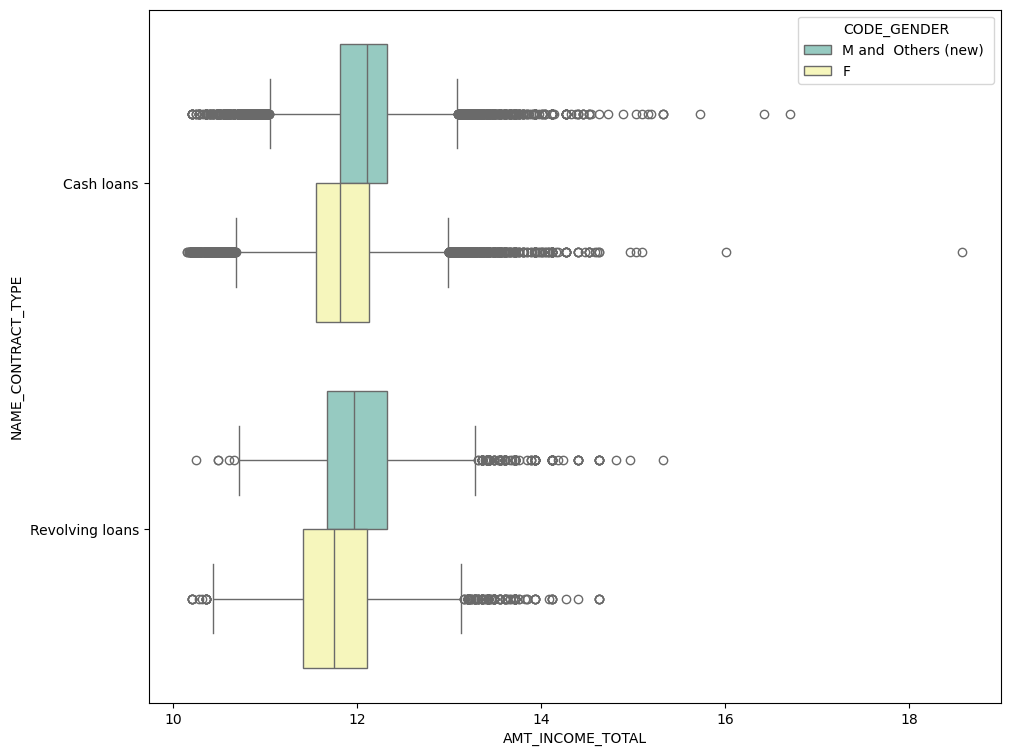

In [ ]:
## 比较不同性别在两种贷款类型下的 对数收入分布
plt.figure(figsize=(11,9))
sns.boxplot(y='NAME_CONTRACT_TYPE', x=np.log(train_app.AMT_INCOME_TOTAL),hue="CODE_GENDER",data=train_app, palette="Set3")
#很明显的是不管是哪一种贷款方式，男性的收入水平都是高于女性的
# 再分别看不同的贷款方式，现金贷的人数是要比循环贷的人数更多的，且大部分收入水平高的人群也倾向于现金贷

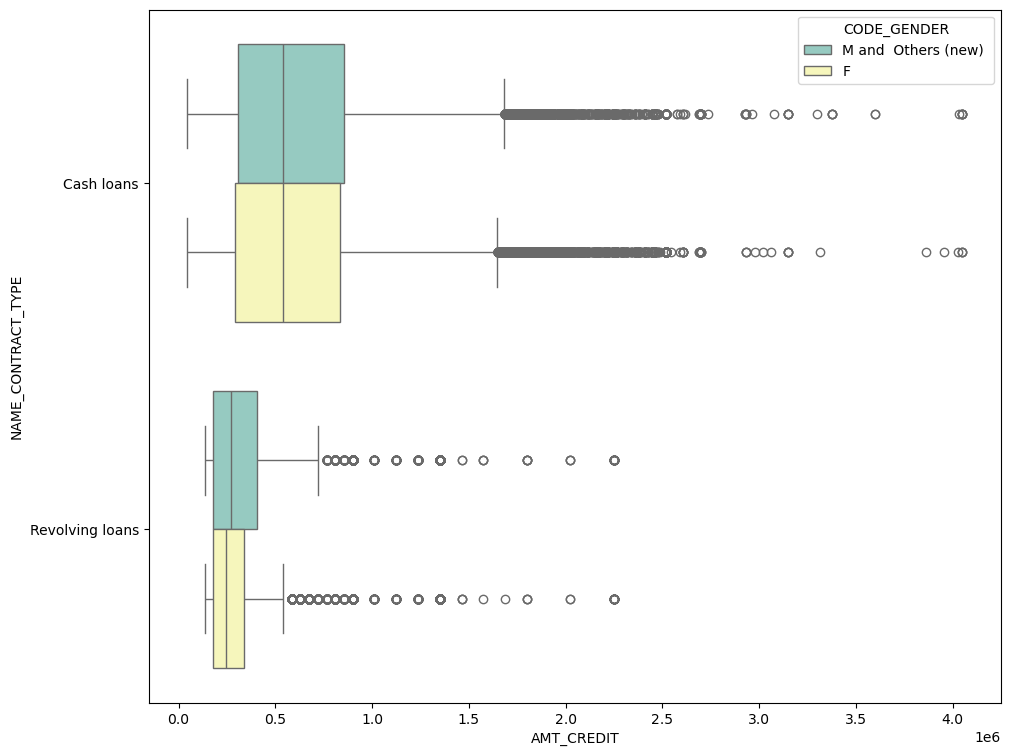

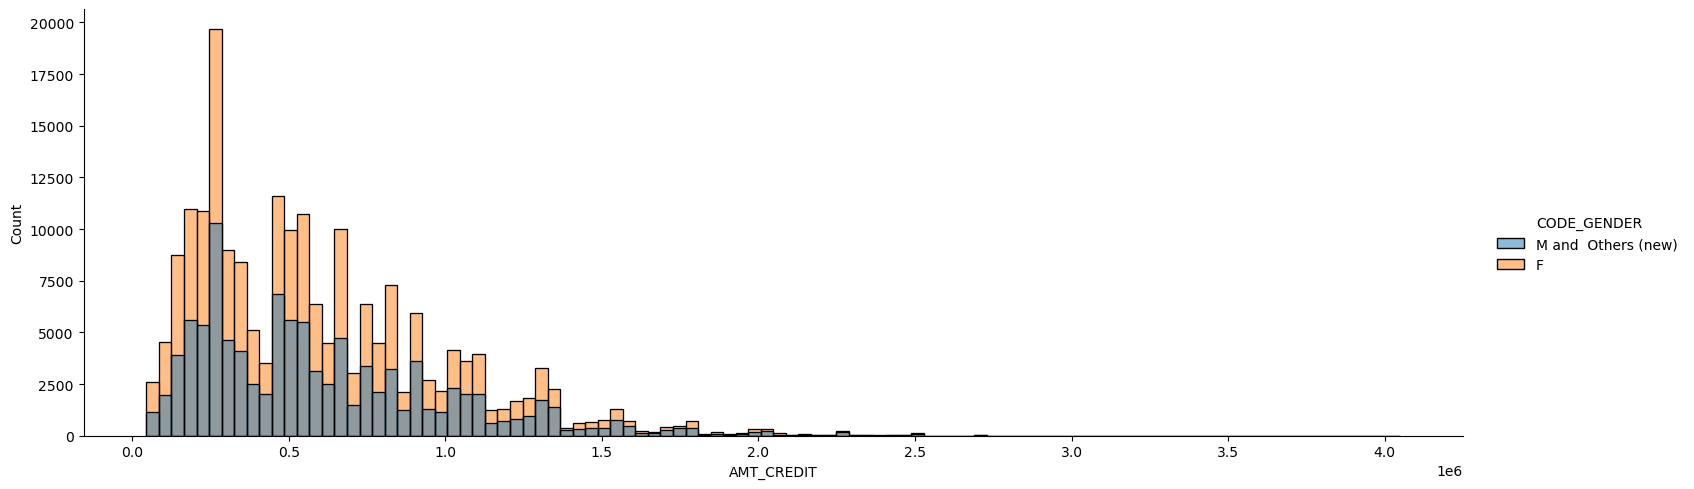

In [ ]:
## 比较不同性别下的，贷款类型和贷款金额之间的关系
plt.figure(figsize=(11,9))
sns.boxplot(x='AMT_CREDIT',y="NAME_CONTRACT_TYPE",hue="CODE_GENDER",data=train_app, palette="Set3")

## 分箱图很明显的发现了，大部分人群还是倾向于使用现金贷，少部分人群使用循环贷且贷款金额较少。。
# 很巧妙的发现在男女现金贷款的分布是出奇的一致。，，
# 不禁想问，性别和贷款金额上又有什么关系呢
sns.displot(train_app,x='AMT_CREDIT',hue="CODE_GENDER",kde=False, bins=100, height=5,aspect=3)

# 呈巨大的右偏正态分布

<Axes: xlabel='AMT_CREDIT', ylabel='NAME_TYPE_SUITE'>

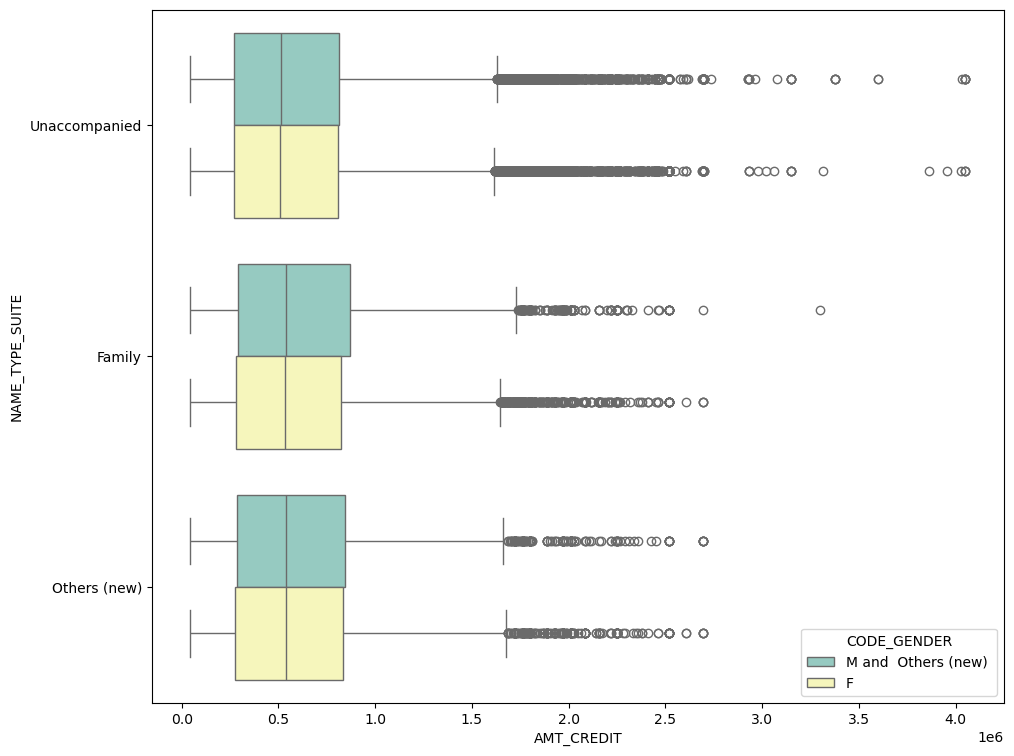

In [ ]:
## 研究在不同性别下的，贷款的金额和家人的陪伴情况下的关系
plt.figure(figsize=(11,9))
sns.boxplot(x='AMT_CREDIT',y="NAME_TYPE_SUITE",hue="CODE_GENDER",data=train_app, palette="Set3")
## 会发现性别并不会呈现出较大的额区别
## 贷款金额低于150w时的贷款金额和有无家人陪伴没有什么关系，但是很明显的是金额大于150w时的贷款都是自己一个人去的

Text(0.5, 1.0, 'Boxplot of Goods Price by Gender')

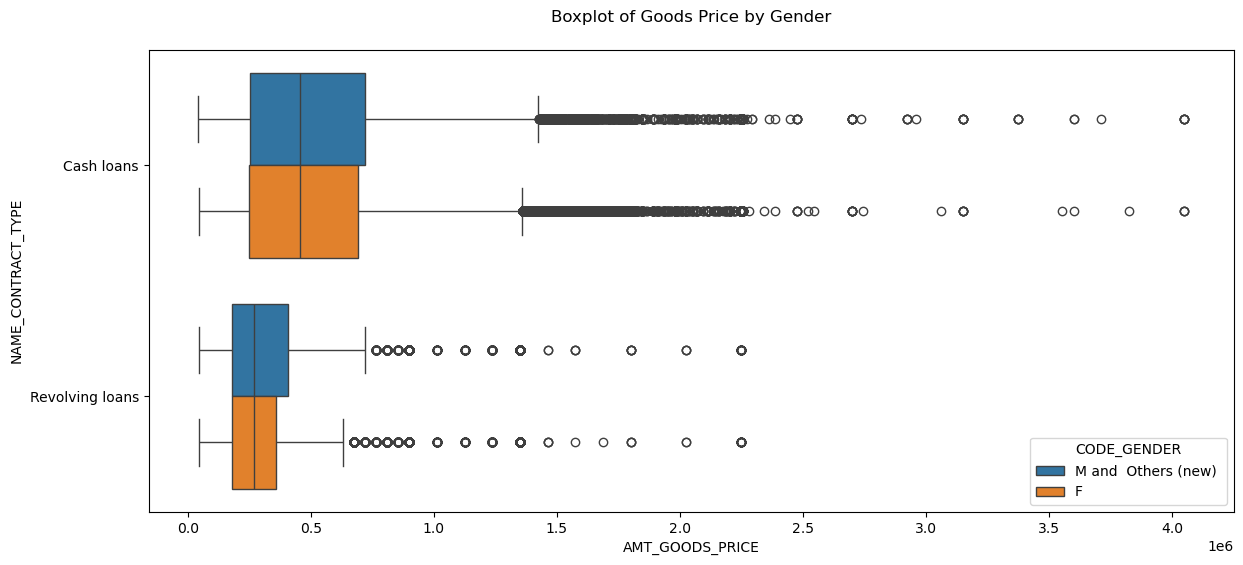

In [ ]:
### 研究在不同性别下的，贷款方式和消费金额之间的关系
plt.figure(figsize=(14,6))
sns.boxplot(x='AMT_GOODS_PRICE', y="NAME_CONTRACT_TYPE",hue='CODE_GENDER', data=train_app)
plt.title("Boxplot of Goods Price by Gender", pad=20)

# 采用现金贷的消费金额明显比循环贷的消费金额较大，是不是现金贷的贷款金额多的缘故？？？所以下面开始研究贷款金额和消费金额之间的关系
#  性别在这期间并没有明显的区别

<Axes: xlabel='AMT_GOODS_PRICE', ylabel='AMT_CREDIT'>

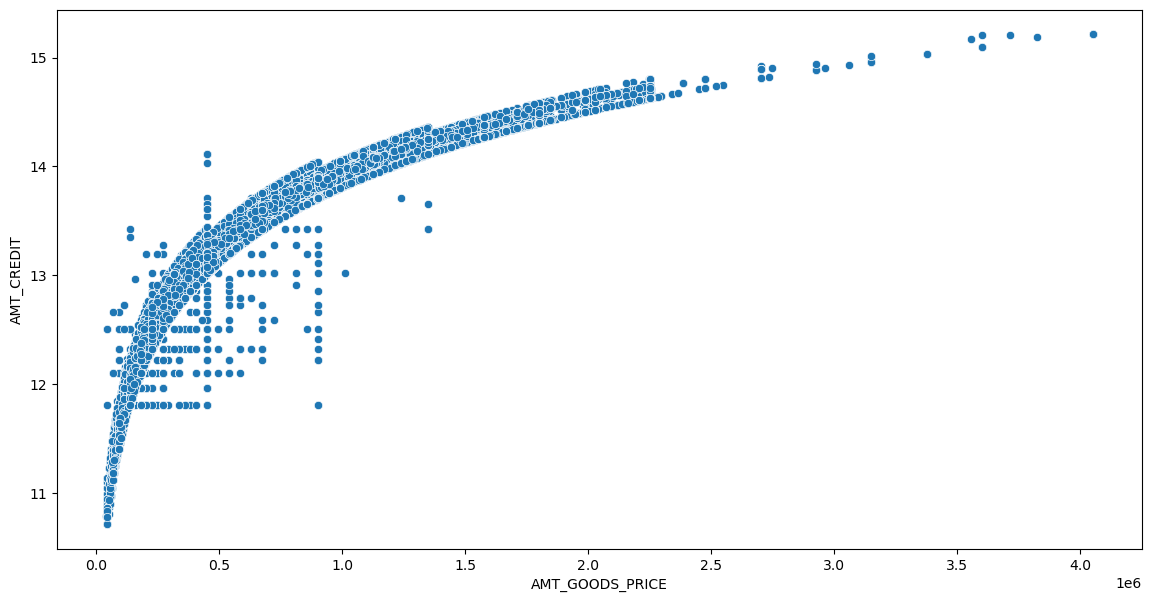

In [ ]:
## 采用散点图来看贷款金额的对数  和消费金额之间的关系
plt.figure(figsize=(14,7))
sns.scatterplot(y=np.log(train_app['AMT_CREDIT']),x='AMT_GOODS_PRICE',data=train_app)
# 忽略离群点可看，贷款金额的对数值和 消费金额是很明显的正相关

<Axes: xlabel='AMT_GOODS_PRICE', ylabel='AMT_INCOME_TOTAL'>

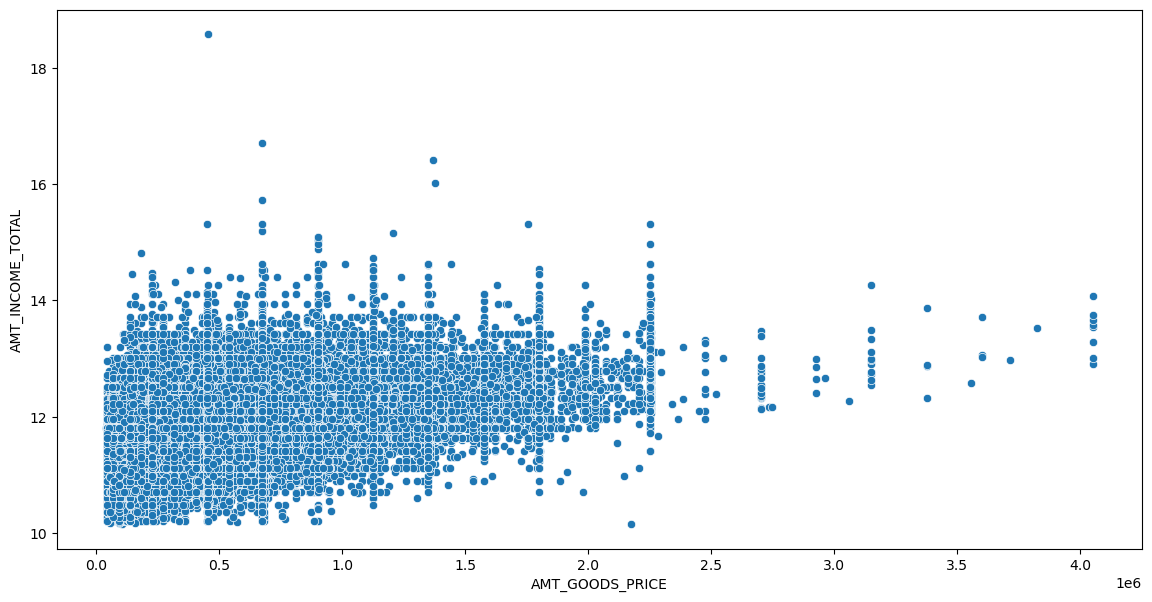

In [ ]:
# 消费金额和收入情况的关系
plt.figure(figsize=(14,7))
sns.scatterplot(y=np.log(train_app['AMT_INCOME_TOTAL']),x='AMT_GOODS_PRICE',data=train_app)

# 数据点非常密集，集中在左侧（低价格区域），随着商品价格上升，数据点逐渐稀疏，这表明绝大多数客户购买的是 低价商品，高价商品很少被使用

Text(0.5, 1.0, 'Log Income vs Good Price (by Family Status)')

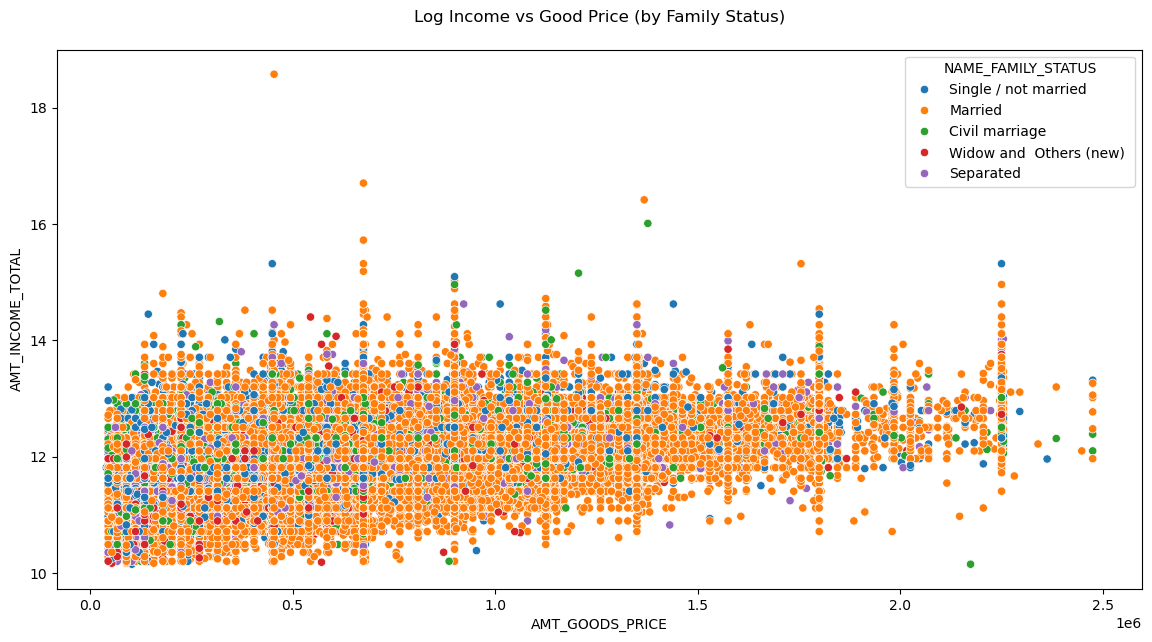

In [ ]:
# 再去思考这里的如果是在不同婚姻状况（NAME_FAMILY_STATUS）下的，收入情况与消费金额之间的差异
plt.figure(figsize=(14,7))
sns.scatterplot(y=np.log(train_app['AMT_INCOME_TOTAL']),x='AMT_GOODS_PRICE', hue='NAME_FAMILY_STATUS',data=train_app.query('AMT_GOODS_PRICE <= 2500000'))
plt.title("Log Income vs Good Price (by Family Status)", pad=20)

# 大部分都是已婚的状态

## 可以再试试NAME_INCOME_TYPE(收入来源)，NAME_EDUCATION_TYPE(受教育程度)去观察差异性

Text(0.5, 1.0, 'Log Income vs Good Price (by EDUCATION_TYPE)')

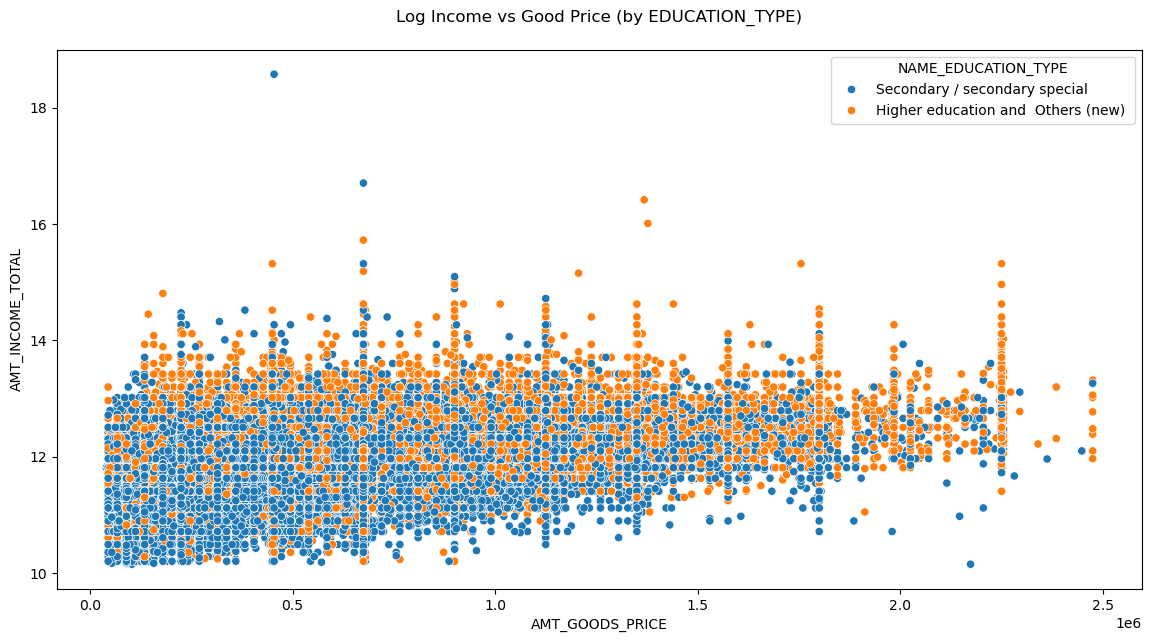

In [ ]:
plt.figure(figsize=(14,7))
sns.scatterplot(y=np.log(train_app['AMT_INCOME_TOTAL']),x='AMT_GOODS_PRICE', hue='NAME_EDUCATION_TYPE',data=train_app.query('AMT_GOODS_PRICE <= 2500000'))
plt.title("Log Income vs Good Price (by EDUCATION_TYPE)", pad=20)

#高等教育者收入稍高，但消费行为与中等教育者相似


<Axes: xlabel='TARGET', ylabel='CODE_GENDER'>

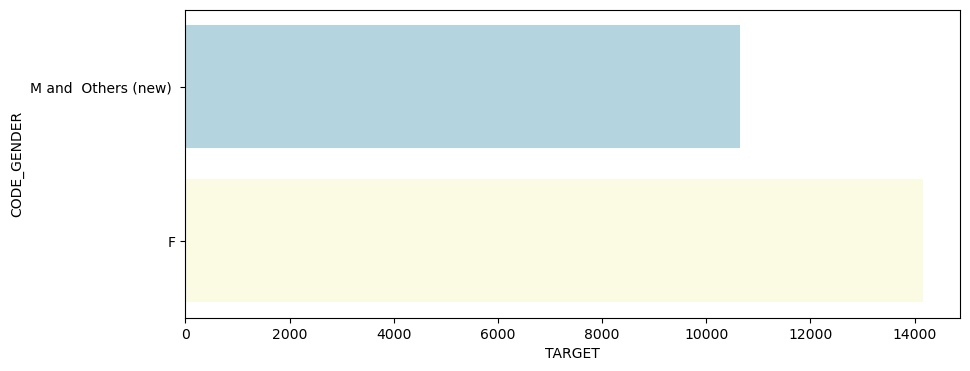

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(y='CODE_GENDER',x='TARGET', data = train_app, ci=None, palette = ['lightblue','lightyellow'], orient='h', estimator = np.sum)
##在违约用户中的男女比例，发现女性要不男性多将近1/4，，所以这就不得不引起我们注意，违约情况是否和性别有关系？？？



<Axes: title={'center': 'Barplot of Defaults By Gender'}, ylabel='CODE_GENDER'>

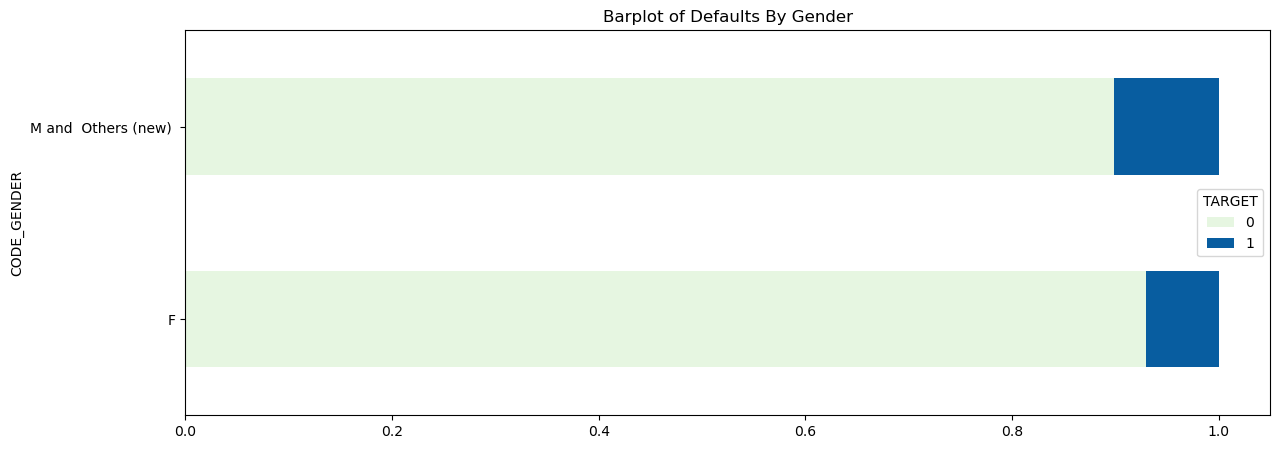

In [ ]:
# 从列联表的角度去观察违约情况和性别之间的关系
from matplotlib.colors import ListedColormap
target_gender=pd.crosstab(   # crosstab()是计算两个或多个分类变量之间的列联表
    index=train_app["CODE_GENDER"], 
    columns=train_app["TARGET"],
    normalize="index"  # # 按每个性别内部标准化 → 得到**条件概率**
)
target_gender.plot(kind="barh",stacked=True,figsize=(14,5),colormap=ListedColormap(sns.color_palette("GnBu", 10)), title = 'Barplot of Defaults By Gender')

#  可以发现女性较之男性相比的违约概率更大一些，下面从统计的角度去检测违约与性别之间的显著情况


In [ ]:
from scipy.stats import chi2_contingency
target_gender_2=pd.crosstab(index=train_app["CODE_GENDER"],
                            columns=train_app["TARGET"])
chi2, p, dof, expected = chi2_contingency(target_gender_2)

print(f"卡方统计量 (Chi2): {chi2:.4f}")
print(f"P 值 (p-value): {p:.10f}")
print(f"自由度 (dof): {dof}")
print("\n期望频数表（如果两变量独立）:")
print(expected)
# 由于p值<0.05，所以可以认为违约和性别情况是显著有关的

卡方统计量 (Chi2): 919.8136
P 值 (p-value): 0.0000000000
自由度 (dof): 1

期望频数表（如果两变量独立）:
[[186104.6119586  16343.3880414]
 [ 96581.3880414   8481.6119586]]


Text(0.5, 1.0, 'Boxplot of Age relating to Defaut Results')

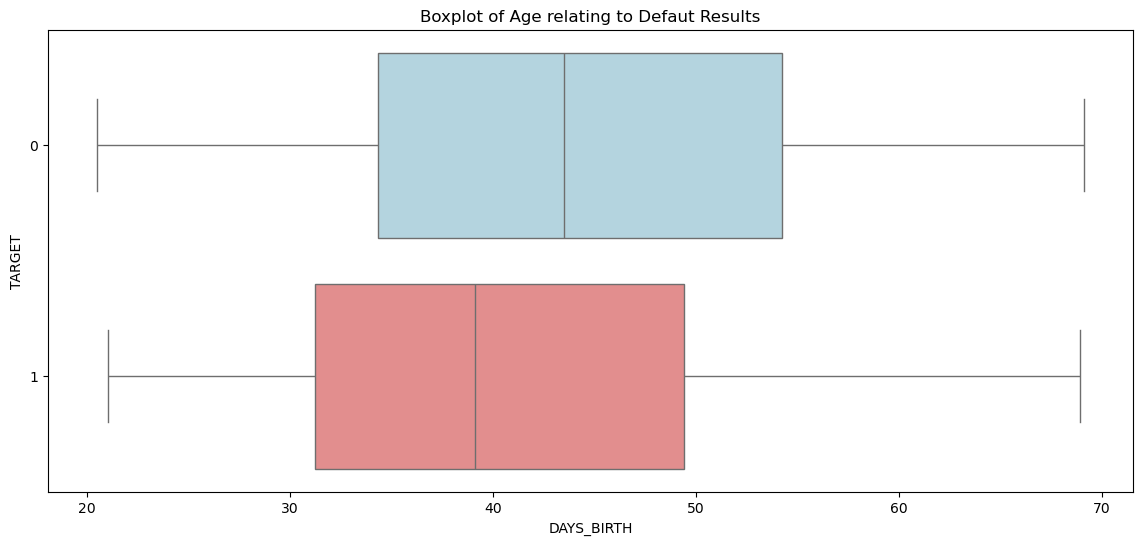

In [ ]:
# 借贷时的年龄和违约情况之间的关系，注意此时的DAYS_BIRTH都是如-9461，-16765，这种需要除以-365来换算年龄
plt.figure(figsize=(14,6))
sns.boxplot(x=train_app['DAYS_BIRTH']/-365, y='TARGET', data=train_app, orient="h",palette=["lightblue", "lightcoral"] )
plt.title("Boxplot of Age relating to Defaut Results")
# 对于违约用户的年龄大约在30-40岁也即是中壮青年阶段

Text(0.5, 1.0, 'Boxplot of Occupation Type and (Log)AMT_INCOME_TOTAL by Target')

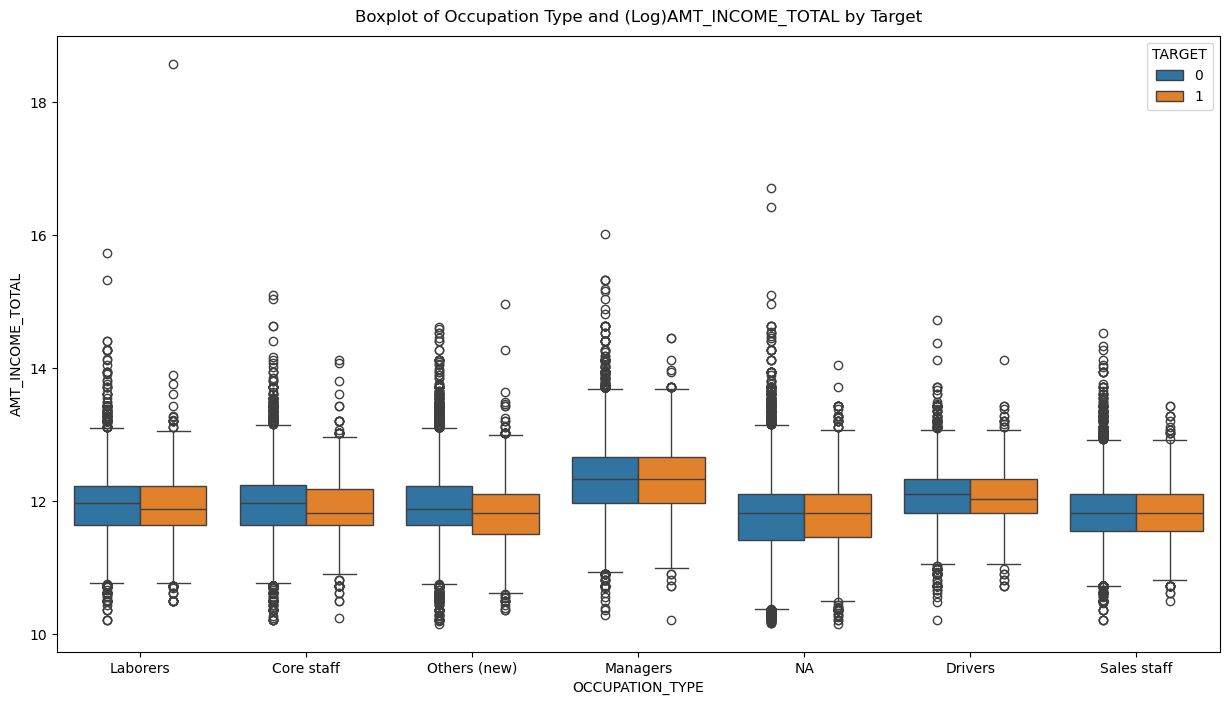

In [ ]:
## 下面来看在违约情况下的，职业类型和收入情况(取对数)的关系
plt.figure(figsize=(15,8))
sns.boxplot(x='OCCUPATION_TYPE',y=np.log(train_app['AMT_INCOME_TOTAL']),hue="TARGET", data=train_app)
plt.title("Boxplot of Occupation Type and (Log)AMT_INCOME_TOTAL by Target", pad=10)
# 在labors，Core staff，drivers违约用户的收入相较于同职业情况下不违约的用户收入较低的，



Text(0.5, 1.0, 'Boxplot of Occupation Type and Amount Credit by Target')

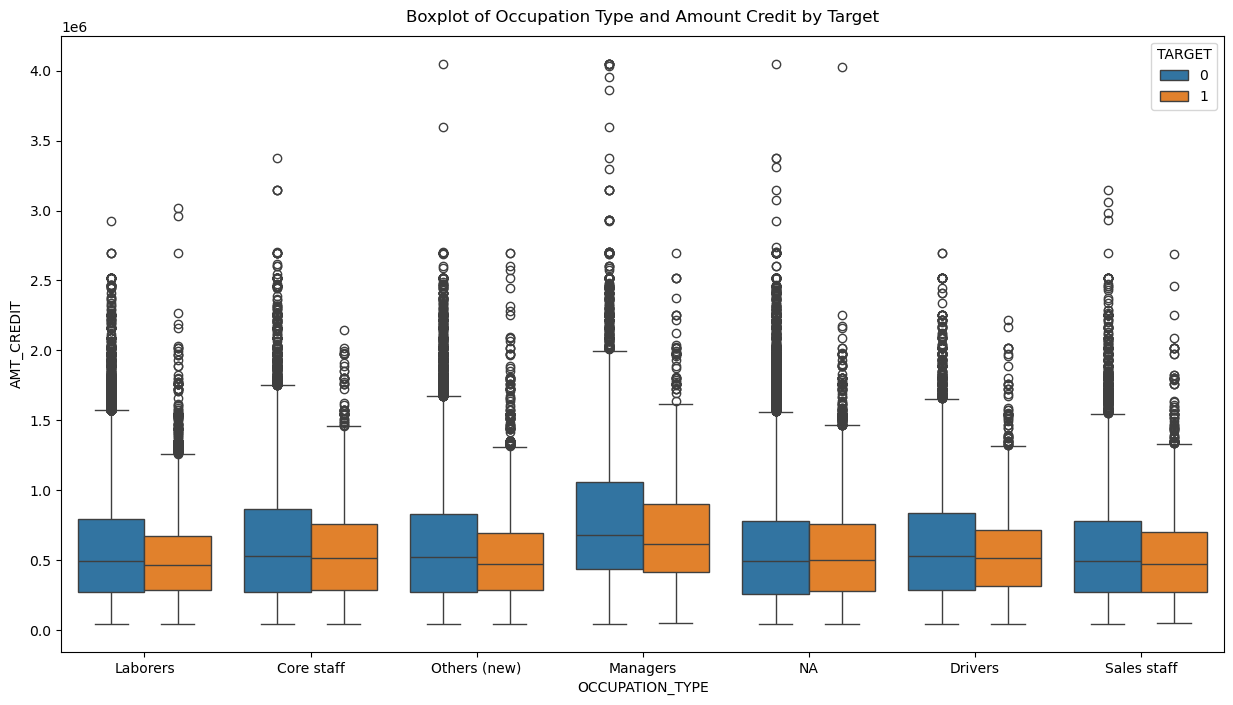

In [ ]:
# 这时候思考，不同职业下的违约与借贷金额的关系
plt.figure(figsize=(15,8))
sns.boxplot(x='OCCUPATION_TYPE',y='AMT_CREDIT',hue="TARGET", data=train_app)
plt.title("Boxplot of Occupation Type and Amount Credit by Target", pad=10)

# 很容易发现高收入人群的借贷金额较大，但是违约率也较低。而对于中低收入者人群借贷金额较低但是违约率也较高

<Axes: >

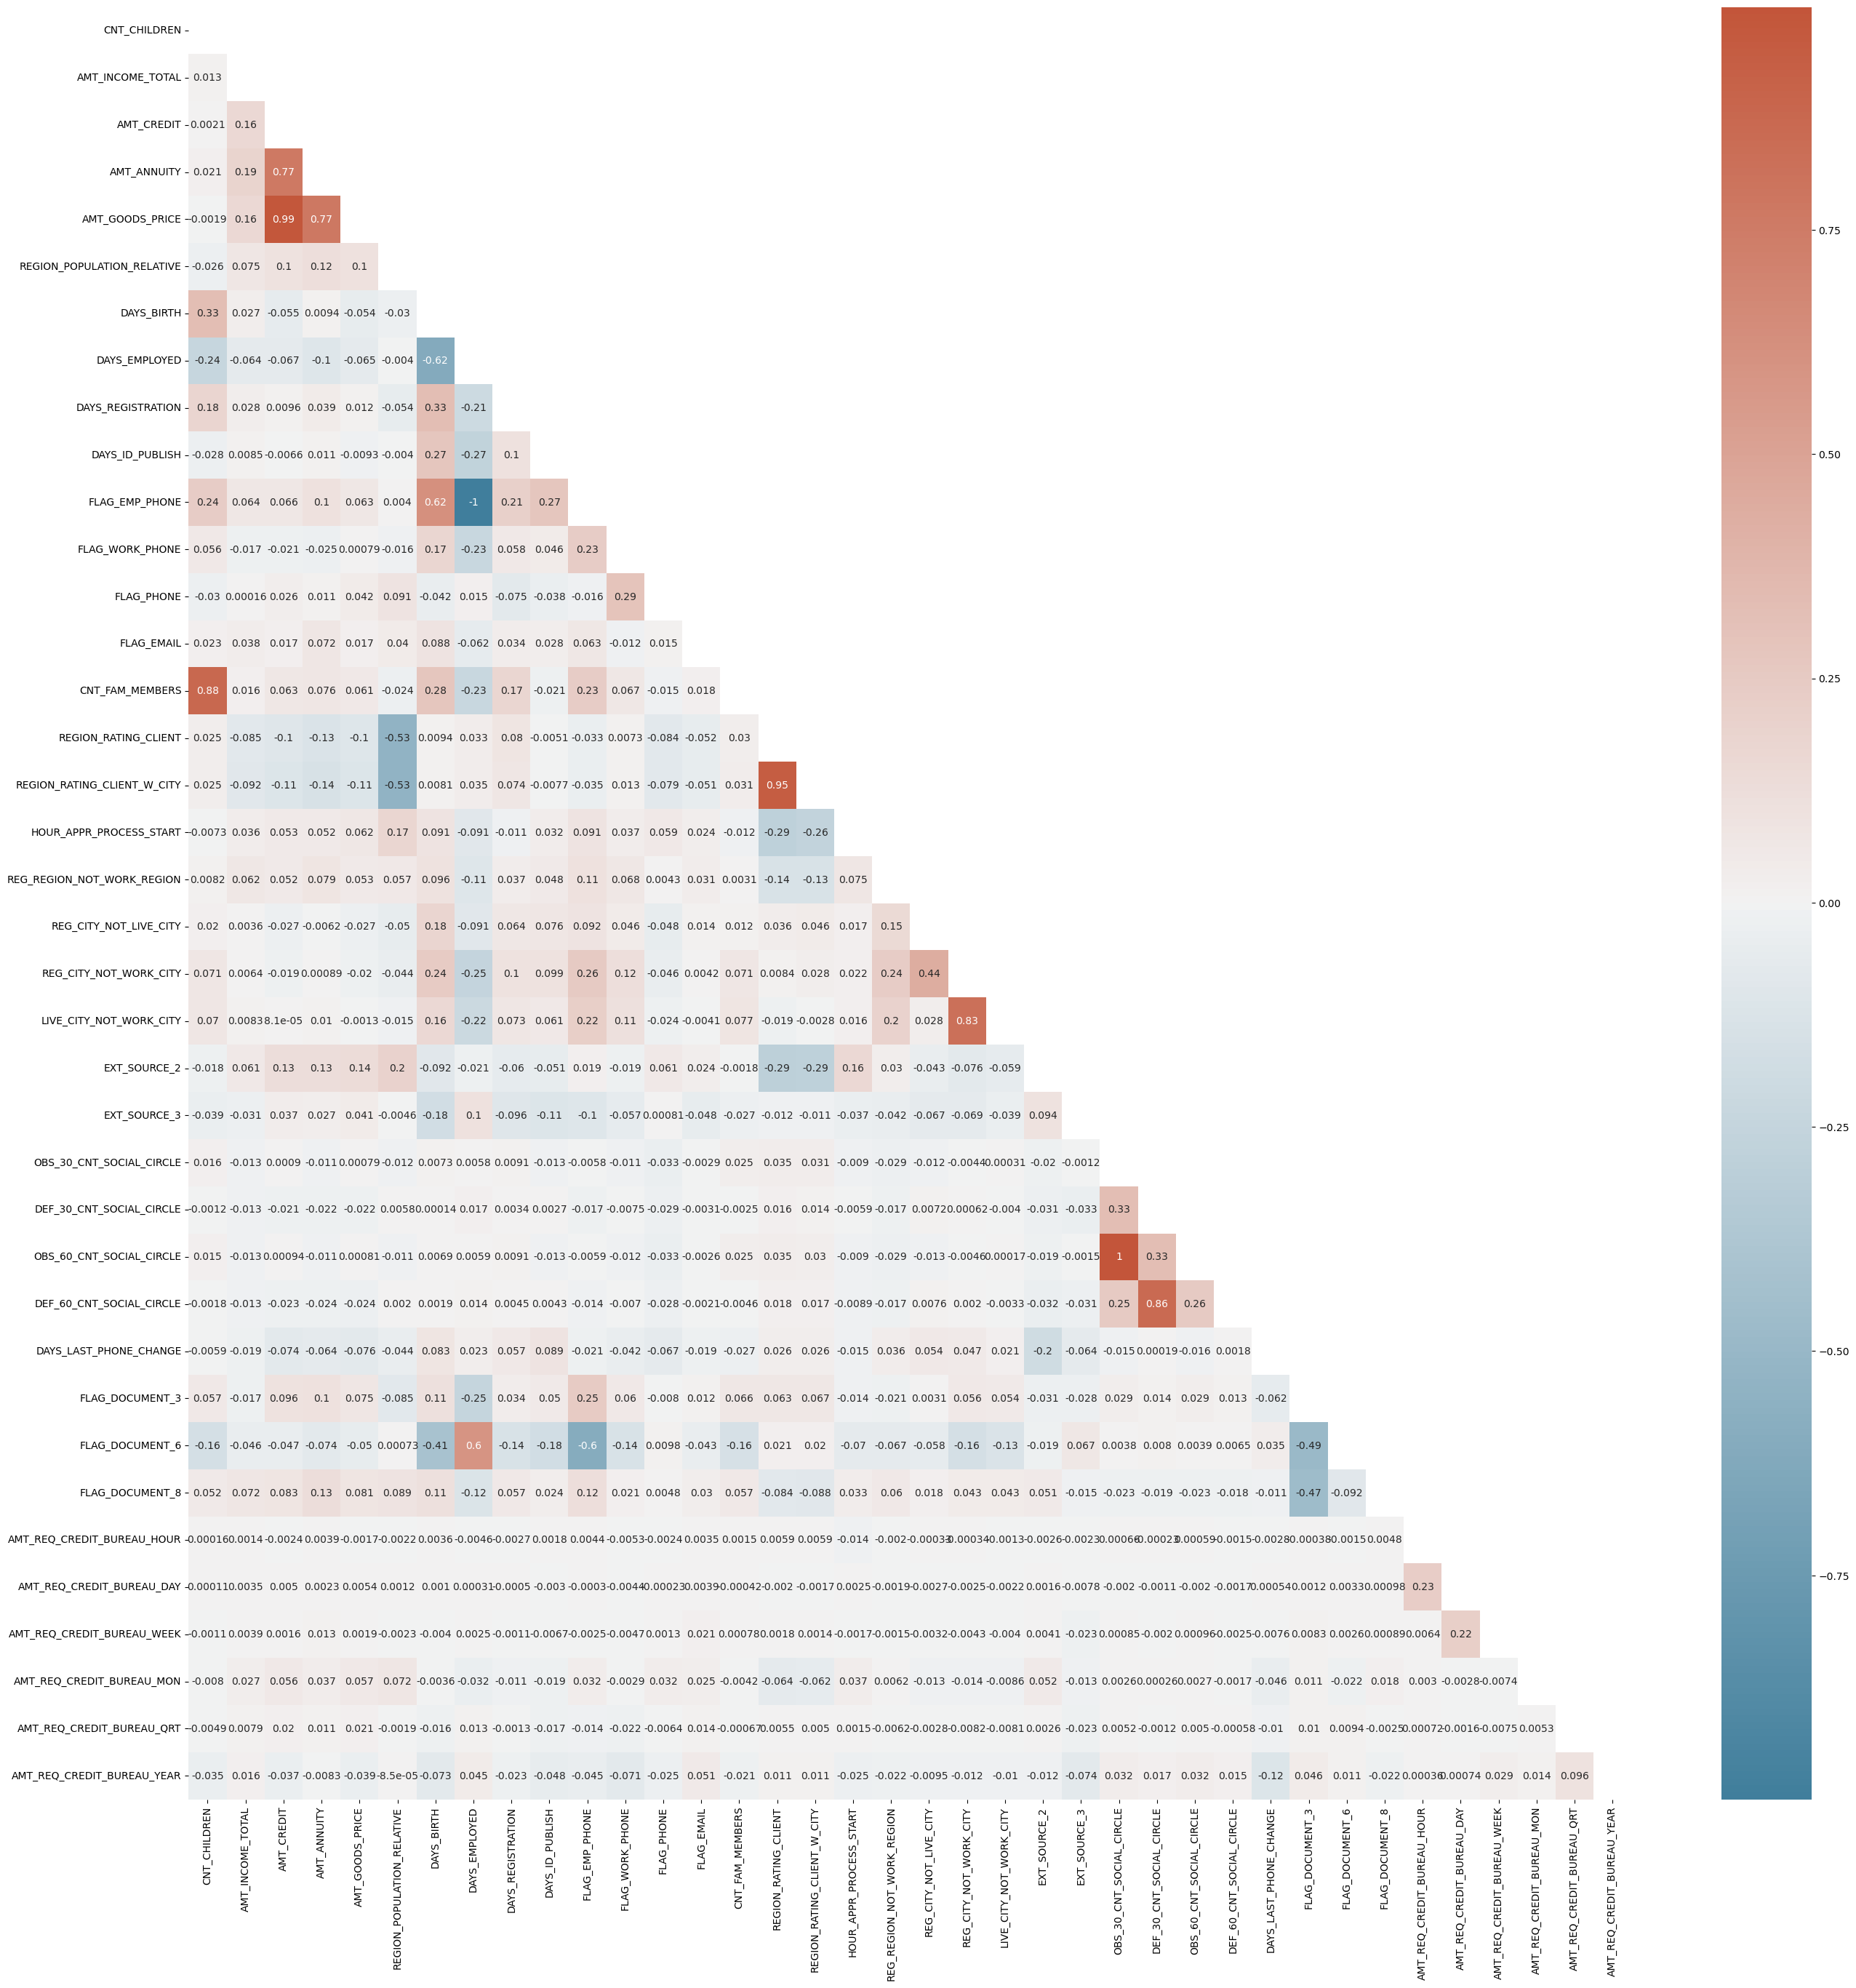

In [ ]:
#  相关性热力图：为下一步的特征工程做辅助
master_cont = list(filter(lambda x: rebalance_df_2[x].dtype not in ["object", 'O'], rebalance_df_2.columns))   # 筛选的是数值型特征
corr = train_app[master_cont].drop(['SK_ID_CURR'], axis=1).corr()  # 生成相关系数矩阵，corr(i,j)取值范围是[-1,1]
mask = np.triu(np.ones_like(corr, dtype=bool))   # 创建一个上三角掩码
cmap = sns.diverging_palette(230, 20, as_cmap=True)   # 定义一个发散型颜色映射（diverging colormap），用于更好地区分正/负相关。

plt.figure(figsize=(32,32))
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap)
# 贷款金额与贷款年限（AMT_ANNUITY），消费金额之间有很强的正相关，贷款年限和消费金额也有很强的相关性
# 结合城市因素对客户居住地区的评级（REGION_RATING_CLIENT_W_CITY）与REGION_RATING_CLIENT有很强的相关性，所以这里可以只取一个评分
# 客户逾期30天和客户逾期60天之间也存在较高的相关性
# 客户在申请贷款前60天更换手机号 与 前30天更换手机号 也有很强的相关性0.86
# 子女数量CNT_CHILDREN 和 家庭数量 CNT_FAM_MEMBERS也是很强的相关性的0.88
# FLAG_EMP_PHONE and DAYS_EMPLOYED之间的相关性是-1，所以有必要去分析

In [ ]:
year_count=train_app["DAYS_EMPLOYED"]/-365
train_app["DAYS_EMPLOYED"][train_app["DAYS_EMPLOYED"]>200000]
# 由结果可知，即使DAYS_EMPLOYED代表了申请贷款前的工作年限是天数, 简单粗暴的直接删掉在之后的模型的准确性并不太好。。发现等于365243的就有55374个，大概占了总数居的5%
train_app["DAYS_EMPLOYED"][train_app["DAYS_EMPLOYED"]==365243]

8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

In [17]:
train_app['DAYS_EMPLOYED_ANOM'] = train_app["DAYS_EMPLOYED"] == 365243
test_app['DAYS_EMPLOYED_ANOM'] =  test_app["DAYS_EMPLOYED"] == 365243
train_app["DAYS_EMPLOYED"].replace({365243:np.nan},inplace=True)
test_app["DAYS_EMPLOYED"].replace({365243:np.nan},inplace=True)

In [ ]:
##结合前面热点图的分析。我们可以删除下面几列
cols_drop = ['CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_WORK_CITY',
             'OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE']
train_app.drop(cols_drop, axis=1, inplace=True)
test_app.drop(cols_drop, axis=1, inplace=True)


In [15]:
## 第四部分：特征工程
# 先进行独热编码函数的编写。因为特征有数值型和非数值型的，所以有必要编写一套函数
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def ohe_transform(df):
    df_new=pd.DataFrame()
    cat_names=list(filter(lambda x:df[x].dtype in ["object","O"],df.columns))
    con_names=list(filter(lambda x:df[x].dtype not in ["object","O"],df.columns))
    if cat_names !=[]:
        for col in cat_names:
            # le=LabelEncoder()                         # 将字符串类别转为整数标签
            # a=le.fit_transform(df[col]).reshape(-1,1)
            # OneHotEncoder 本身可以直接处理字符串类别（只要设置 handle_unknown='ignore' )
            ohe=OneHotEncoder(sparse_output=False,handle_unknown="ignore")    # sparse_output=False 表示输出稠密数组（NumPy array），而不是稀疏矩阵，便于转为 DataFrame。 
            encoded_array =  ohe.fit_transform(df[[col]])  # 传给onehotencoder应该是一个二维的数据，所以不应该是Series的格式
            column_names=ohe.get_feature_names_out([col])  # # 注意这里是 [col],传入的是列表的格式。。。。当然如果不用for循环就没有上述这些问题了 
            df_encoded = pd.DataFrame(encoded_array, columns=column_names, index=df.index)
    if con_names !=[]:
        df_new = pd.concat([df[con_names], df_encoded], axis=1)
    return df_new


# 简洁版的直接对非数值型特征进行独热编码
def ohe_convert(df, drop_first=True):
    cat_names=list(filter(lambda x:df[x].dtype in ["object","O"],df.columns))
    if cat_names!=[]:
        return  pd.get_dummies(df, columns = cat_names, drop_first=drop_first)  # pd.get_dummies() 会自动：处理字符串类别 ,生成新列名，格式为：原列名_类别值,,,保留原始数值列不动
    else:
        return  df
train_app=ohe_convert(train_app,drop_first=False)
test_app=ohe_convert(test_app,drop_first=False)
bureau_df=ohe_convert(bureau_df,False)
bureau_balance_df=ohe_convert(bureau_balance_df,False)
credit_card_balance_df=ohe_convert(credit_card_balance_df,False)
installments_payments_df=ohe_convert(installments_payments_df,False)
POS_CASH_balance_df=ohe_convert(POS_CASH_balance_df,False)
previous_application_df=ohe_convert(previous_application_df,False)
# detect_null_columns(previous_application_df.copy())


In [16]:
# 由于在installments_payments.csv中有SK_ID_PREV，SK_ID_CURR也就是对一个客户可能有两个ID，我们会将其进行拆分，最后以SK_ID_CURR的保存汇聚...
# installments_payments中包含的是客户每一期的还款情况（应还多少，实际还多少，应该在什么时候还，逾期天数），以及还款进度（NUM_INSTALMENT_NUMBER）
## 把同一笔历史贷款的所有分期记录压缩成一行，提取该笔贷款的整体行为特征
binary_names=list(filter(lambda x :
                         installments_payments_df[x].nunique()==2 and 
                         0 in installments_payments_df[x].unique() and
                         1 in installments_payments_df[x].unique(),
                         installments_payments_df.columns
                         ))
print(binary_names)  # 返回为空说明是在这个csv中没有二分类特征的
exclu_cols=list(installments_payments_df.columns[~installments_payments_df.columns.isin(['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER', 'SK_ID_CURR','SK_ID_PREV'])])
install_pay_agg_same_application=installments_payments_df.groupby(["SK_ID_PREV","SK_ID_CURR"]).agg(
    dict(
        zip(
        ['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER']+
        exclu_cols,
        ["nunique","count"]+["mean"]*len(exclu_cols)    # 对应的每一列使用的聚合函数：
    )
  )
).reset_index()

# 同一个客户的所有历史贷款特征进一步汇总，得到客户全局画像。
excul_ID_cols= list(installments_payments_df.columns[~installments_payments_df.columns.isin(['SK_ID_CURR','SK_ID_PREV'])])
install_pay_agg_same_credit=install_pay_agg_same_application.groupby(["SK_ID_CURR"]).agg(
    dict(
        zip(
            excul_ID_cols,
            ["mean"]*len(excul_ID_cols)
            )
        )
    ).reset_index()
install_pay_agg_same_credit=install_pay_agg_same_credit.rename(
    columns=dict(
        zip(
            excul_ID_cols,
            list(map(lambda x: "AVG_"+x,excul_ID_cols))
        )
    )
)
install_pay_agg_same_credit.head(20)



[]


,SK_ID_CURR,AVG_NUM_INSTALMENT_VERSION,AVG_NUM_INSTALMENT_NUMBER,AVG_DAYS_INSTALMENT,AVG_DAYS_ENTRY_PAYMENT,AVG_AMT_INSTALMENT,AVG_AMT_PAYMENT
0,100001,1.500000,3.500000,-2275.000000,-2280.916667,5647.200000,5647.200000
1,100002,2.000000,19.000000,-295.000000,-315.421053,11559.247105,11559.247105
2,100003,1.333333,8.333333,-1164.333333,-1171.781746,78558.479286,78558.479286
3,100004,2.000000,3.000000,-754.000000,-761.666667,7096.155000,7096.155000
4,100005,2.000000,9.000000,-586.000000,-609.555556,6240.205000,6240.205000
5,100006,1.333333,5.333333,-260.666667,-285.966667,241944.225000,241944.225000
6,100007,1.200000,13.200000,-1087.881319,-1090.768539,12122.995738,11671.540210
7,100008,1.250000,8.750000,-1318.931818,-1301.861742,28547.512398,28275.099784
8,100009,1.000000,6.375000,-885.125000,-894.558333,9563.553000,9563.553000
9,100010,1.000000,10.000000,-904.000000,-915.900000,27449.208000,27449.208000


In [17]:
## 这里对需要首先清楚SK_ID_CURR是当前客户的ID，但是当前客户的SK_ID_PREV是有几个不同的贷款，也即是一对多的关系，先按照[SK_ID_PREV,SK_ID_CURR]可以分出当前用户的之前贷款记录以及平均贷款金额，
## 第2次聚合的方式是对[SK_ID_CURR]是在上面的基础上求出目前为止的当前用户ID的还款记录，给出了一个总体的、平均的评估。
def attrbution_app_and_credit(df):
    ##############
    binary_names=list(filter(lambda x :
                            df[x].nunique()==2 and 
                            0 in df[x].unique() and
                            1 in df[x].unique() ,
                            df.columns
                            ))
    #print(binary_names)  #y有两个2分类变量的['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Others (new)']
    contnames = list(set(df.columns) - set(binary_names))
    id_cols=list(df.columns[:2])   # 也即是SK_ID_CURR和SK_ID_PREV
    contnames = [col for col in contnames if col not in id_cols]
    # 采取和上述一样聚合的方式
    ##########1
    df_agg_same_app = df.groupby(id_cols).agg(
        dict(
            zip(contnames + binary_names, 
                ['mean']*len(contnames) + ['sum']*len(binary_names))
            )
    ).reset_index()

    #  22222
    curr_col=df.columns[1]  # 也就是SK_ID_CURR
    df_agg_same_credit = df_agg_same_app.groupby([curr_col]).agg(
        dict(
            zip(contnames + binary_names,
                 ['mean']*len(contnames+binary_names))
            )
    ).reset_index()
    df_agg_same_credit=df_agg_same_credit.rename(
        columns=dict(
            zip(
                contnames + binary_names,
                list(map(lambda x : "AVG_"+x,contnames+binary_names))
            )
        )
    )
    return df_agg_same_credit
pos_bal_agg_same_credit=attrbution_app_and_credit(POS_CASH_balance_df.copy())
ccard_bal_agg_same_credit=attrbution_app_and_credit(credit_card_balance_df.copy())




In [19]:
## bureau_balance 只有一列是SK_ID_BUREAU，还有两行是MONTHS_BALANCE，STATUS
binary_names_1 = list(filter(lambda x: bureau_balance_df[x].nunique() == 2 and 
                           0 in bureau_balance_df[x].unique() and 
                           1 in bureau_balance_df[x].unique(), 
                        bureau_balance_df.columns))
print(binary_names_1)
contnames_1 = list(set(bureau_balance_df.columns) - set(binary_names_1))
contnames_1.remove('SK_ID_BUREAU')
print(contnames_1)

# 遍历列名并进行转换,可以对bool值直接进行转换成数值，true是1，false是0
for col in binary_names_1:
    bureau_balance_df[col] = bureau_balance_df[col].astype(int)
bureau_bal_agg_same_credit = bureau_balance_df.groupby('SK_ID_BUREAU').agg(
    dict(zip(contnames_1 + binary_names_1, 
             ['mean']*len(contnames_1)+["sum"]*len(binary_names_1)))
).reset_index()
#bureau_bal_agg_same_credit[contnames_1] = bureau_bal_agg_same_credit[contnames_1].apply(round)

bureau_bal_agg_same_credit.rename(columns = dict(zip(
    contnames_1 + binary_names_1,
    list(map(lambda x: 'AVG_'+x, contnames_1))+list(map(lambda x: "SUM_"+x,binary_names_1)) )
    ), inplace=True)

bureau_bal_agg_same_credit.head()




['STATUS_0', 'STATUS_C', 'STATUS_X and  Others (new) ']
['MONTHS_BALANCE']


,SK_ID_BUREAU,AVG_MONTHS_BALANCE,SUM_STATUS_0,SUM_STATUS_C,SUM_STATUS_X and Others (new)
0,5001709,-48.0,0,86,11
1,5001710,-41.0,5,48,30
2,5001711,-1.5,3,0,1
3,5001712,-9.0,10,9,0
4,5001713,-10.5,0,0,22


In [20]:
binary_names_2 = list(filter(lambda x: previous_application_df[x].nunique() == 2 and
                              0 in previous_application_df[x].unique() and
                                1 in previous_application_df[x].unique(), 
                        previous_application_df.columns))
contnames_2 = list(set(previous_application_df.columns) - set(binary_names_2))
contnames_2.remove('SK_ID_CURR')
contnames_2.remove('SK_ID_PREV')


# Group-By Summary info by SK_ID_CURR from the aggregated table of previous applications above
prev_app_agg_same_credit = previous_application_df.groupby(['SK_ID_CURR']).agg(
    dict(zip(['SK_ID_PREV'] + contnames_2 + binary_names_2, ['mean']*len(['SK_ID_PREV'] + contnames_2 + binary_names_2)))
).reset_index()

prev_app_agg_same_credit[contnames_2] = prev_app_agg_same_credit[contnames_2].apply(round)

prev_app_agg_same_credit.rename(columns = dict(zip(
    contnames_2 + binary_names_2,
    list(map(lambda x: 'AVG_'+x, contnames_2+ binary_names_2
    ))
)), inplace=True)

prev_app_agg_same_credit.head()

,SK_ID_CURR,SK_ID_PREV,AVG_HOUR_APPR_PROCESS_START,AVG_AMT_GOODS_PRICE,AVG_CNT_PAYMENT,AVG_AMT_CREDIT,AVG_AMT_ANNUITY,AVG_DAYS_DECISION,AVG_SELLERPLACE_AREA,AVG_AMT_APPLICATION,...,AVG_NAME_YIELD_GROUP_low_normal,AVG_NAME_YIELD_GROUP_middle,AVG_PRODUCT_COMBINATION_Card Street,AVG_PRODUCT_COMBINATION_Cash,AVG_PRODUCT_COMBINATION_Cash X-Sell: low,AVG_PRODUCT_COMBINATION_Cash X-Sell: middle,AVG_PRODUCT_COMBINATION_Others (new),AVG_PRODUCT_COMBINATION_POS household with interest,AVG_PRODUCT_COMBINATION_POS industry with interest,AVG_PRODUCT_COMBINATION_POS mobile with interest
0,100001,1.369693e+06,13.0,24836.0,8.0,23787.0,3951.0,-1740.0,23.0,24836.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0
1,100002,1.038818e+06,9.0,179055.0,24.0,179055.0,9252.0,-606.0,500.0,179055.0,...,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0
2,100003,2.281150e+06,15.0,435436.0,10.0,484191.0,56554.0,-1305.0,533.0,435436.0,...,0.333333,0.666667,0.0,0.0,0.333333,0.0,0.0,0.333333,0.333333,0.0
3,100004,1.564014e+06,5.0,24282.0,4.0,20106.0,5357.0,-815.0,30.0,24282.0,...,0.000000,1.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0
4,100005,2.176837e+06,10.0,78469.0,12.0,20077.0,8032.0,-536.0,18.0,22309.0,...,0.000000,0.000000,0.0,0.5,0.000000,0.0,0.0,0.000000,0.000000,0.5


In [21]:
bureau_combined = bureau_df.merge(bureau_bal_agg_same_credit, on='SK_ID_BUREAU', how='left')
bureau_combined['BUREAU_BAL_NA'] = 1  # 创建一个新的列
bureau_combined.loc[bureau_combined.isnull().any(axis=1), 'BUREAU_BAL_NA'] = 0   # 检测在合并之后的，这个客户的某笔历史贷款是否有详细的历史行为记录。。如果0代表没有历史记录，1代表有历史记录
bureau_combined.fillna(0, inplace=True)
#bureau_combined[bureau_combined["BUREAU_BAL_NA"]==0]

In [22]:
binary_names = list(filter(lambda x: bureau_combined[x].nunique() == 2 and 0 in bureau_combined[x].unique() and 1 in bureau_combined[x].unique(), 
                        bureau_combined.columns))
contnames = list(set(bureau_combined.columns) - set(binary_names))
contnames.remove('SK_ID_CURR')
contnames.remove('SK_ID_BUREAU')

bureau_combined_agg = bureau_combined.groupby('SK_ID_CURR').agg(
    dict(zip(['SK_ID_BUREAU'] + contnames + binary_names, ["count"]+['mean']*len(contnames) + ['sum']*len(binary_names)))
).reset_index()

bureau_combined_agg[contnames] = bureau_combined_agg[contnames].apply(round)

bureau_combined_agg.rename(columns = dict(zip(
    contnames + binary_names,
    list(map(lambda x: 'AVG_'+x, contnames)) + list(map(lambda x: 'SUM_'+x, binary_names))
)), inplace=True)
# bureau_combined_agg.rename(columns={"SK_ID_BUREAU":"Counts_id_in_bureau"},inplace=True)

bureau_combined_agg.head()

,SK_ID_CURR,SK_ID_BUREAU,AVG_SUM_STATUS_0,AVG_SUM_STATUS_X and Others (new),AVG_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM_LIMIT,AVG_DAYS_CREDIT_UPDATE,AVG_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,AVG_DAYS_CREDIT_ENDDATE,...,AVG_DAYS_CREDIT,AVG_CREDIT_DAY_OVERDUE,AVG_AVG_MONTHS_BALANCE,SUM_CREDIT_ACTIVE_Active and Others (new),SUM_CREDIT_ACTIVE_Closed,SUM_CREDIT_CURRENCY_Others (new),SUM_CREDIT_CURRENCY_currency 1,SUM_CREDIT_TYPE_Consumer credit,SUM_CREDIT_TYPE_Credit card and Others (new),SUM_BUREAU_BAL_NA
0,100001,7,4.0,4.0,0.0,0.0,-93.0,207624.0,85241.0,82.0,...,-735.0,0.0,-12.0,3,4,0,7,7,0,7
1,100002,8,6.0,5.0,0.0,3999.0,-500.0,108132.0,30723.0,-344.0,...,-874.0,0.0,-22.0,2,6,0,8,4,4,8
2,100003,4,0.0,0.0,0.0,202500.0,-816.0,254350.0,0.0,-544.0,...,-1401.0,0.0,0.0,1,3,0,4,2,2,0
3,100004,2,0.0,0.0,0.0,0.0,-532.0,94519.0,0.0,-488.0,...,-867.0,0.0,0.0,0,2,0,2,2,0,0
4,100005,3,5.0,1.0,0.0,0.0,-54.0,219042.0,189470.0,439.0,...,-191.0,0.0,-3.0,2,1,0,3,2,1,3


In [23]:
## 现在就是按SK_ID_CURR链接在一块

train_final = train_app.merge(prev_app_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_prevapp')).merge(
    ccard_bal_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_ccard')).merge(
    pos_bal_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_posbal')) .merge(
    install_pay_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_installpay')).merge(
    bureau_combined_agg, on='SK_ID_CURR', how='left', suffixes=(None, '_bureau'))
train_final.head()

test_final = test_app.merge(prev_app_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_prevapp')).merge(
    ccard_bal_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_ccard')).merge(
    pos_bal_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_posbal')) .merge(
    install_pay_agg_same_credit, on='SK_ID_CURR', how='left', suffixes=(None, '_installpay')).merge(
    bureau_combined_agg, on='SK_ID_CURR', how='left', suffixes=(None, '_bureau'))
test_final["SK_ID_BUREAU"]

0         7.0
1         3.0
2         4.0
3        12.0
4         NaN
         ... 
48739     5.0
48740     NaN
48741     5.0
48742    17.0
48743     3.0
Name: SK_ID_BUREAU, Length: 48744, dtype: float64

In [24]:
# 对于在Bureau有过记录的记为1，没有过往贷款记录的记为0
train_final['Bureau_flag'] = 1
test_final['Bureau_flag'] = 1
train_final.loc[train_final.SK_ID_BUREAU.isnull(),'Bureau_flag']=0
test_final.loc[test_final.SK_ID_BUREAU.isnull(),'Bureau_flag']=0
# 同样的在 在HC上没有国王记录的记为0
train_final['HC_prevapp_flag'] = 1
test_final['HC_prevapp_flag'] = 1
train_final.loc[train_final.SK_ID_PREV.isnull(),'HC_prevapp_flag']=0
test_final.loc[test_final.SK_ID_PREV.isnull(),'HC_prevapp_flag']=0
train_final.fillna(0,inplace=True)
test_final.fillna(0,inplace=True)
train_final.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/train_final.csv")
test_final.to_csv("D:/Desktop/机器学习的数据集/Home Credit Default Risk/test_final.csv")


In [25]:
del prev_app_agg_same_credit,ccard_bal_agg_same_credit,pos_bal_agg_same_credit,install_pay_agg_same_credit,bureau_combined_agg
del bureau_combined,bureau_bal_agg_same_credit
## Delete unused dataset
del previous_application_df,previous_application
del credit_card_balance_df,credit_card_balance
del installments_payments_df,installments_payments
del POS_CASH_balance, POS_CASH_balance_df
del bureau_balance,bureau_balance_df

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,...,SUM_CREDIT_CURRENCY_currency 1,SUM_DAYS_ENDDATE_FACT_NA,SUM_DAYS_ENDDATE_FACT_Others (new),SUM_AMT_CREDIT_SUM_LIMIT_0.0,SUM_AMT_CREDIT_SUM_LIMIT_NA and Others (new),SUM_CREDIT_TYPE_Consumer credit,SUM_CREDIT_TYPE_Credit card and Others (new),SUM_STATUS_0,SUM_STATUS_C,SUM_STATUS_X and Others (new)


In [ ]:
## 


Series([], Name: Bureau_flag, dtype: int64)